# Assignment 1: Unsupervised Learning  

**Assignment 1 primarily focus on applying both the K-means and PCA to the World Development Indicators dataset.**  
**We will preprocess the data, apply clustering, test different initialization strategies, and evaluate results with PCA and visualizations.**


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## 1.Data Preprocessing  
**steps:**   
**1.Load the dataset**  
**2.Melt and Pivot the dataset to get into good structure of each row representing COUNTRY/YEAR with multiple clumns(Indicators)**  
**3.Handle missing values by check various threshholds for wch we get a good balance between completness and coverage.**  
**4.Normalize features**  
**5.Save cleaned data for later use**

In [50]:
path = "WDICSV.csv"
raw_data= pd.read_csv(path)
print("Success in loading in the data")

Success in loading in the data


In [51]:
#Melting the data
years = [col for col in raw_data.columns if col.isdigit()]
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
melted_data = raw_data.melt(id_vars = id_vars,value_vars = years,var_name="Year",value_name="Value")
#here i change the years to be numeric for easier filter processig
melted_data["Year"] = pd.to_numeric(melted_data["Year"],errors="coerce")

#pivoting to make it presented as an N by D matrix(where N is number of datapoints and D is the number of indicators)
pivoted = melted_data.pivot_table(index = ['Country Name', 'Country Code', 'Year'],columns= 'Indicator Name',values='Value').reset_index()
#print(pivoted) 

In [52]:
#saving the processed data to visualize
output_path = "WDI_pivoted.csv"
pivoted.to_csv(output_path, index=False)


In [53]:
#testing different thresholds using a for loop
thresholds= [(0.3, 0.4), (0.5, 0.6),(0.4, 0.6),(0.6, 0.4),(0.5, 0.5),(0.6, 0.6),(0.7, 0.7), (0.5, 0.7), (0.7, 0.8)]#our thresholds
pivoted_copy = pivoted.copy()
features = pivoted_copy.drop(columns=['Country Name', 'Country Code', 'Year'])#keeping only the indicators
meta_data = pivoted[['Country Name', 'Country Code', 'Year']]
results = []# to be used later with t-SNE

for row_thresh ,col_thresh in thresholds:
    #for iterartion wil create a new copy
    features_copy = features.copy()
    
    #from her will first filter the rows(Years) and the the columns(Indicators)
    row_completeness = features_copy.notna().mean(axis=1)
    filtered_by_rows = features_copy[row_completeness >=row_thresh]
    #by columns(Indicators)
    column_completeness = filtered_by_rows.notna().mean(axis=0)
    filtered_data = filtered_by_rows.loc[:, column_completeness >= col_thresh]
    filtered_shape = filtered_data.shape

    results.append({'row_threshold': row_thresh,'col_threshold': col_thresh,'data': filtered_data,'row_mask': row_completeness >= row_thresh,'n_rows': filtered_shape[0],'n_cols': filtered_shape[1]})

    print(f"The thresholds for this iteration are ({row_thresh}, {col_thresh}) >>> Final Shape: {filtered_shape}")


The thresholds for this iteration are (0.3, 0.4) >>> Final Shape: (9280, 914)
The thresholds for this iteration are (0.5, 0.6) >>> Final Shape: (4338, 882)
The thresholds for this iteration are (0.4, 0.6) >>> Final Shape: (6665, 785)
The thresholds for this iteration are (0.6, 0.4) >>> Final Shape: (2427, 1106)
The thresholds for this iteration are (0.5, 0.5) >>> Final Shape: (4338, 960)
The thresholds for this iteration are (0.6, 0.6) >>> Final Shape: (2427, 973)
The thresholds for this iteration are (0.7, 0.7) >>> Final Shape: (469, 1005)
The thresholds for this iteration are (0.5, 0.7) >>> Final Shape: (4338, 768)
The thresholds for this iteration are (0.7, 0.8) >>> Final Shape: (469, 930)


In [54]:
print("I have choosen the thresholds 0.4 and 0.6")
chosen = None
for result in results:
    if result['row_threshold'] == 0.4 and result['col_threshold'] == 0.6:
        chosen = result
        break

filtered_data = chosen['data']
rows_kept_mask = chosen['row_mask']

filtered_metadata = meta_data[rows_kept_mask].reset_index(drop=True)

#to check if the number of rows are equal
print(f"Are the number of rows equal? {filtered_data.shape[0] == filtered_metadata.shape[0]}")


I have choose the thresholds 0.4 and 0.6
Are the number of rows equal? True


In [55]:
def strategy(strategy, data, return_scaled=True, return_tsne=False):
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.manifold import TSNE
    
    imputer = SimpleImputer(strategy=strategy)#Imputing using one of two strategies
    imputed = imputer.fit_transform(data)
    
    scaler = StandardScaler()#Scaling
    scaled = scaler.fit_transform(imputed)

    results = {}
    if return_scaled:
        results["scaled"] = scaled
        
    if return_tsne:
        tsne = TSNE(n_components=2, random_state=42)
        results["tsne"] = tsne.fit_transform(scaled)

    return results


In [56]:
#I am getting results for both the mean and median strategies

strategy_mean = strategy("mean", filtered_data, return_scaled=True, return_tsne=True)
scaled_mean = strategy_mean["scaled"]   
tsne_mean = strategy_mean["tsne"] 

strategy_median = strategy("median", filtered_data, return_scaled=True, return_tsne=True)
scaled_median = strategy_median["scaled"] 
tsne_median = strategy_median["tsne"] 

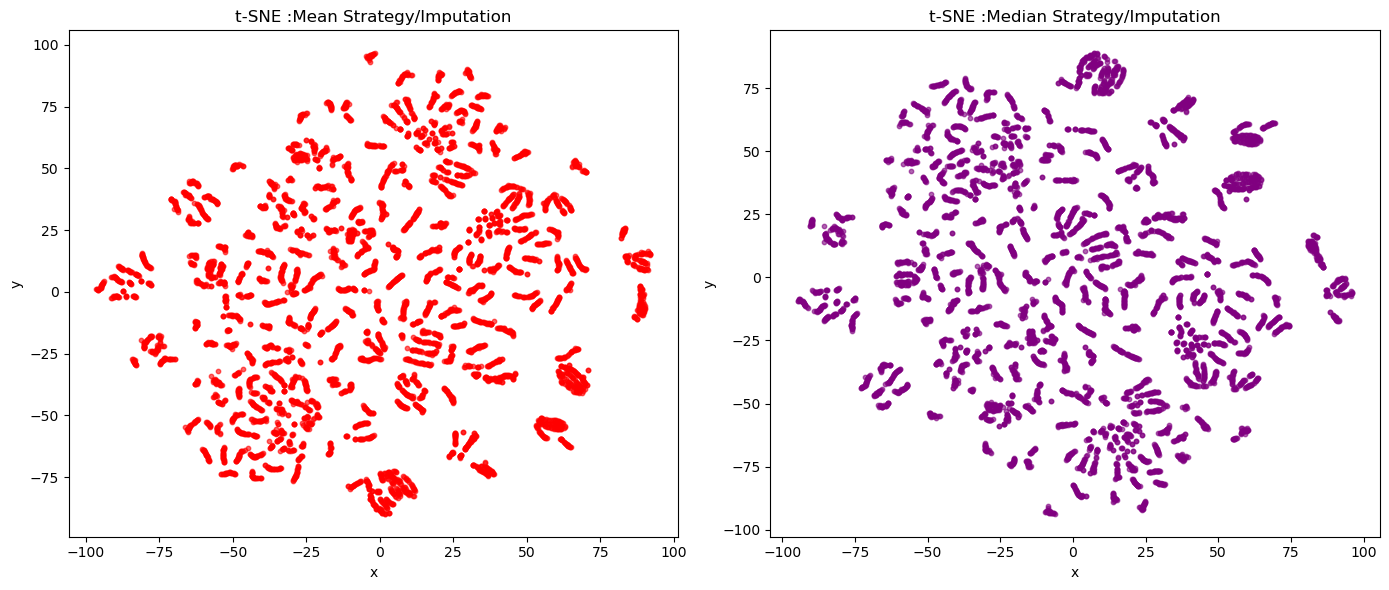

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Plot t-SNE on mean-imputed data
axes[0].scatter(tsne_mean[:,0], tsne_mean[:,1], alpha=0.6, s=10,color="red")
axes[0].set_title("t-SNE :Mean Strategy/Imputation")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
# Plot t-SNE on median-imputed data
axes[1].scatter(tsne_median[:,0], tsne_median[:,1],alpha=0.6, s=10, color="purple")
axes[1].set_title("t-SNE :Median Strategy/Imputation")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

plt.tight_layout()
plt.show()


## PCA before kmeans
**The aim is to find the optimal number of dimesions to keep before applying the k-means**  

In [58]:
def my_pca(data, n_components=2, plot=True):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(data)

    return reduced,pca

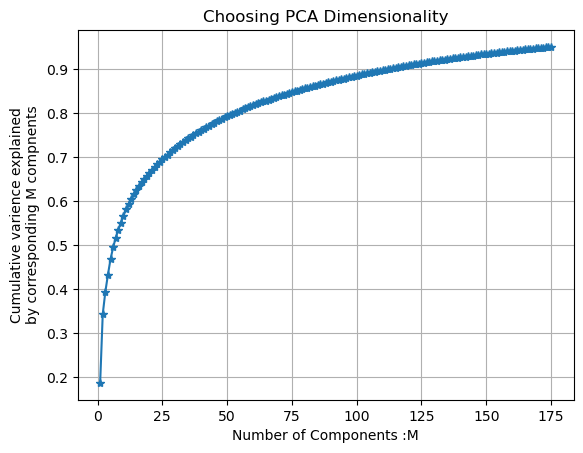

In [59]:
_, pca_model = my_pca(scaled_mean, n_components=175)
explained_var = pca_model.explained_variance_ratio_

cumulative = np.cumsum(explained_var)

plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='*')
plt.xlabel("Number of Components :M")
plt.ylabel("Cumulative varience explained\nby corresponding M compnents")
plt.title("Using cumulative method to find M")
plt.grid(True)
plt.show()

# I choose 175 to be the optimal M as it explains around 95% of the varience  
# I plan to feed this reduced data to my kmeans for comparison

In [60]:
reduced ,pca_model = my_pca(scaled_mean, n_components=175)

## 2. K-means Clustering and Initialization
**Compare the two methods of initialising my centroids**  
**I do the comparison for both the data with all of the indicators and the data with M=175 indicators to see if the PCA improves perfomance**


In [61]:
def centroids_init(data, k, method="random", seed=None):
    generator = np.random.default_rng(seed)
    data_points= data.shape[0]

    if method == "kmeans++":
        centroids = [data[generator.integers(data_points)]]
        for _ in range(1, k):
            distances = np.min(np.linalg.norm(data[:, None] - centroids, axis=2)**2, axis=1)
            probs = distances / distances.sum()
            new_centroid = data[generator.choice(data_points, p=probs)]
            centroids.append(new_centroid)
        return np.array(centroids)

    elif method == "random":
        indices = generator.choice(data_points, size=k, replace=False)
        return data[indices]


def my_kmeans(data,k,maximum_iterations=300,init="random",seed=None,minimum_centroid_shift=1e-4,minimum_loss_improvement=None):
    loss_per_iteration = []
    centroid_shift_per_iteration = []
    current_centroids = centroids_init(data, k, method=init, seed=seed)

    for i in range(maximum_iterations):
        distances = np.linalg.norm(data[:, None] - current_centroids, axis=2)
        centroid_labels = np.argmin(distances, axis=1)

        new_centroids = np.array([data[centroid_labels == j].mean(axis=0) if np.any(centroid_labels ==j) else current_centroids[j]for j in range(k)])#getting new centroids

        final_loss = np.sum((data - current_centroids[centroid_labels])**2)  #getting the loss
        loss_per_iteration.append(final_loss)

        diff = np.linalg.norm(new_centroids - current_centroids) # tracking centroid movement
        centroid_shift_per_iteration.append(diff)

        stop = False
        if diff < minimum_centroid_shift:# checking convergence
            stop = True

        if (minimum_loss_improvement is not None) and (i > 0):
            prev_loss = loss_per_iteration[-2]
            improvement = prev_loss - final_loss
            if improvement < minimum_loss_improvement:
                stop = True

        current_centroids = new_centroids
        if stop:
            break

    return centroid_labels, current_centroids, final_loss, i + 1, loss_per_iteration, centroid_shift_per_iteration

    

For PCA-reduced data (175 dims)
KMEANS++ >>> Final loss: 2993052.30, Iterations: 37
For PCA-reduced data (175 dims)
RANDOM >>> Final loss: 2959592.23, Iterations: 18


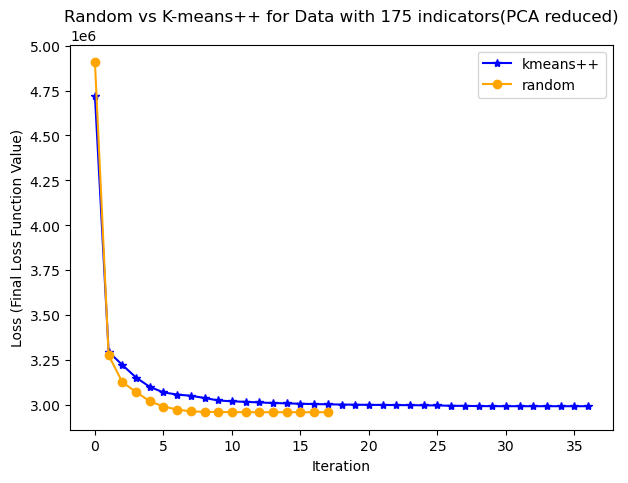

In [62]:
methods = ["kmeans++", "random"]
markers = {"kmeans++": "*", "random": "o"}
colors = {"kmeans++": "blue", "random": "orange"}

plt.figure(figsize=(7,5))

for method in methods:
    labels, centroids, final_loss, total_iterations, loss_per_iteration,centroid_shift_per_iteration = my_kmeans(reduced, k=10, init=method,seed=56)
    plt.plot(loss_per_iteration, marker=markers[method], color=colors[method], label=method)
    print(f"For PCA-reduced data (175 dims)\n{method.upper()} >>> Final loss: {final_loss:.2f}, Iterations: {total_iterations}")

plt.xlabel("Iteration")
plt.ylabel("Loss (Final Loss Function Value)")
plt.title("Random vs K-means++ for Data with 175 indicators(PCA reduced)")
plt.legend()
plt.show()

For Original Data
KMEANS++ >>> Final loss: 3212359.14, Iterations: 59
For Original Data
RANDOM >>> Final loss: 3207115.81, Iterations: 48


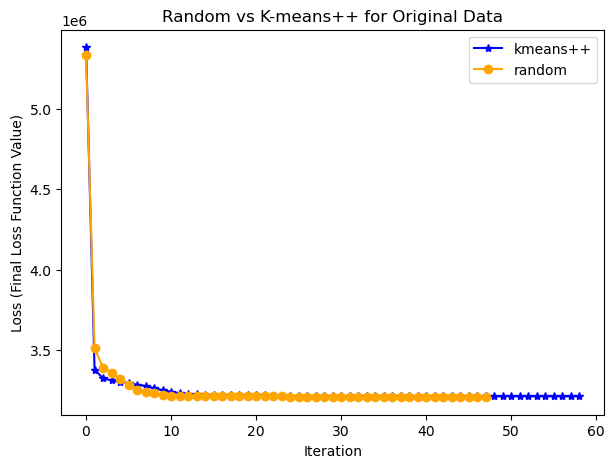

In [63]:
methods = ["kmeans++", "random"]
markers = {"kmeans++": "*","random": "o"}
colors = {"kmeans++": "blue","random": "orange"}

plt.figure(figsize=(7,5))

for method in methods:
    labels, centroids, final_loss, total_iterations, loss_per_iteration,centroid_shift_per_iteration= my_kmeans(scaled_mean, k=10, init=method,seed=56)
    plt.plot(loss_per_iteration, marker=markers[method], color=colors[method], label=method)
    print(f"For Original Data\n{method.upper()} >>> Final loss: {final_loss:.2f}, Iterations: {total_iterations}")

plt.xlabel("Iteration")
plt.ylabel("Loss (Final Loss Function Value)")
plt.title("Random vs K-means++ for Original Data")
plt.legend()
plt.show()

**From the above graphs it is clear that PCA does infact improves the perfomance for clustering**  
**It converges faster and has a lower loss at the end**

## 3. Convergence Criteria
**In this section :The aim is to implement and evaluate multiple different convergence criteria:**  
**maximum iterations**  
**centroid change threshold (when cluster centroids move less than a specified distance)**  
**And inertia change threshold (when the loss function improvement falls below a minimum value)**

## 4. Determining the Optimal K(
**Using the orignal data (to preserve as much of the information regarding the indicators as possible)**

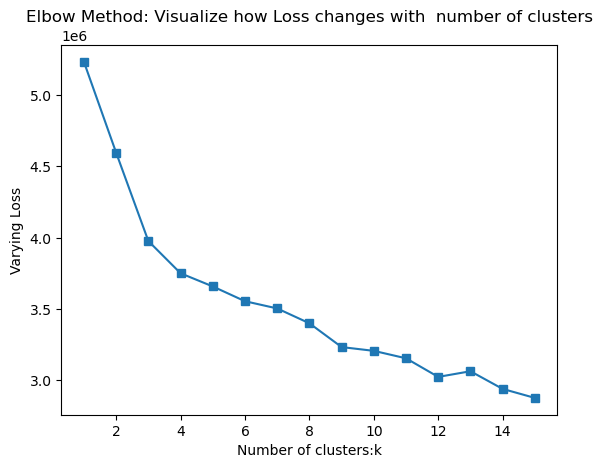

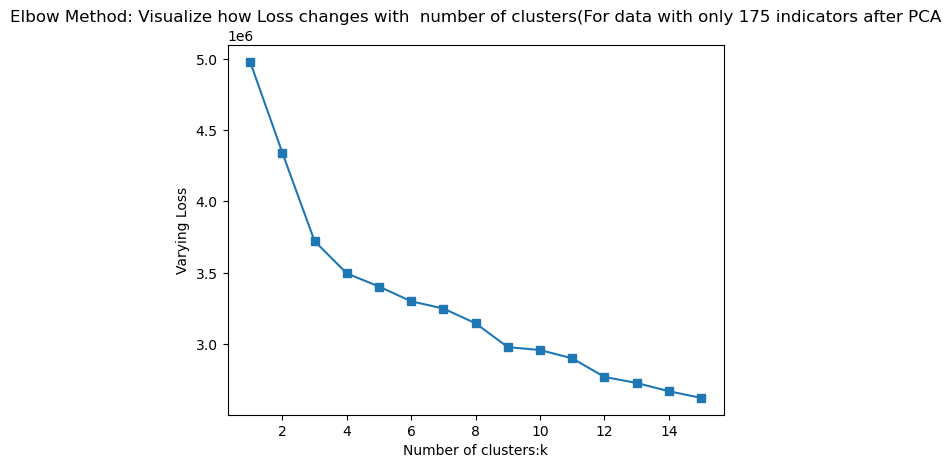

In [64]:
losses = []
k_values = range(1, 16)
for k in k_values:
    labels, centroids, final_loss, total_iterations, loss_per_iteration, centroid_shift_per_iteration = my_kmeans(scaled_mean, k,init="random",seed=56)
    losses.append(final_loss)
plt.plot(k_values, losses, marker="s")
plt.xlabel("Number of clusters:k")
plt.ylabel("Varying Loss")
plt.title("Elbow Method: Visualize how Loss changes with  number of clusters")
plt.show()

losses = []
k_values = range(1, 16)
for k in k_values:
    labels, centroids, final_loss, total_iterations, loss_per_iteration, centroid_shift_per_iteration = my_kmeans(reduced, k,init="random",seed=56)
    losses.append(final_loss)
plt.plot(k_values, losses, marker="s")
plt.xlabel("Number of clusters:k")
plt.ylabel("Varying Loss")
plt.title("Elbow Method: Visualize how Loss changes with  number of clusters(For data with only 175 indicators after PCA")
plt.show()



In [88]:
def visualise_tsne(data, labels, centroids, seed=56):
    data_and_centroids= np.vstack([reduced, centroids])
    tsne = TSNE(n_components=2, random_state=56)
    combined_tsne = tsne.fit_transform(data_and_centroids)

    data_tsne =combined_tsne[:data.shape[0]]
    centroids_tsne = combined_tsne[data.shape[0]:]
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1],c="red", marker="X", s=200, edgecolor="black", label="Centroids")

    plt.title("Visualizing K-means Clusters & Centroids\nusing t-SNE")
    plt.legend()
    plt.show()

## The graph below is for k=3 it is also for task 5 for visualising using t-SNE

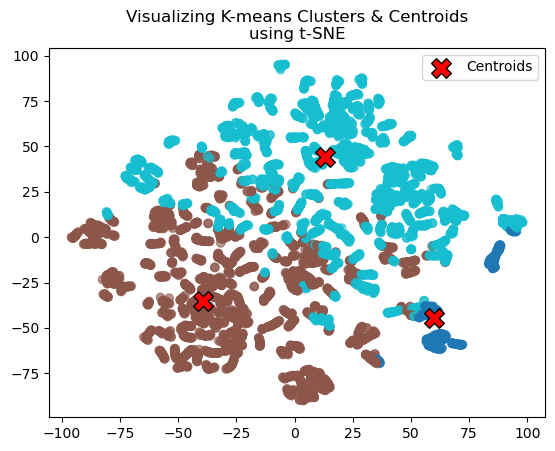

In [91]:
labels, centroids, final_loss, total_iterations, loss_per_iteration, centroid_shift_per_iteration = my_kmeans(reduced, 3,init="random",seed=56)
visualise_tsne(reduced, labels, centroids, seed=56)


## 5. Dimensionality Reduction with PCA
**-Use PCA to plot/visulise the data i have clustered(just when using t-SNE i will use vStack)**  
**-Visualizing both cases >>>2D and 3D**

In [117]:
def pca_visualise(data, labels, centroids, number_of_dims=2, seed=56):
    pca = PCA(n_components=number_of_dims, random_state=seed)

    data_and_centroids= np.vstack([data, centroids])
    combined_pca = pca.fit_transform(data_and_centroids)

    data_pca = combined_pca[:data.shape[0]]
    centroids_pca = combined_pca[data.shape[0]:]

    if number_of_dims == 3:
        print(data_pca)
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], 
                   c=labels, cmap="tab10", alpha=0.6)
        ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],c="yellow", marker="X", s=200, edgecolor="black", label="Centroids")
        ax.set_title("Clusters in 3D PCA space")
        plt.legend()
        plt.show()

    elif number_of_dims == 2:
        print(data_pca)
        plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap="tab10", alpha=0.6)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],c="yellow", marker="X", s=200, edgecolor="black", label="Centroids")
        plt.title("Clusters in 2D PCA space")
        plt.legend()
        plt.show()

    

[[-13.78272078 -16.23790823]
 [-13.77033817 -16.38341962]
 [-13.90471512 -15.73656276]
 ...
 [-10.35831091  -8.16080221]
 [ -9.57743162  -7.31879737]
 [ -7.58209442  -6.24927748]]


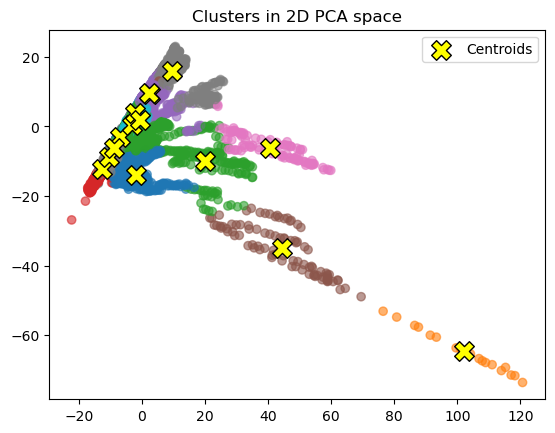

[[-13.78272077 -16.23790831   0.14227183]
 [-13.77033816 -16.38341969   0.11320515]
 [-13.90471511 -15.73656288   0.0906476 ]
 ...
 [-10.3583109   -8.1608023   -1.09990498]
 [ -9.57743161  -7.31879748  -0.69252048]
 [ -7.5820944   -6.24927764  -0.35311371]]


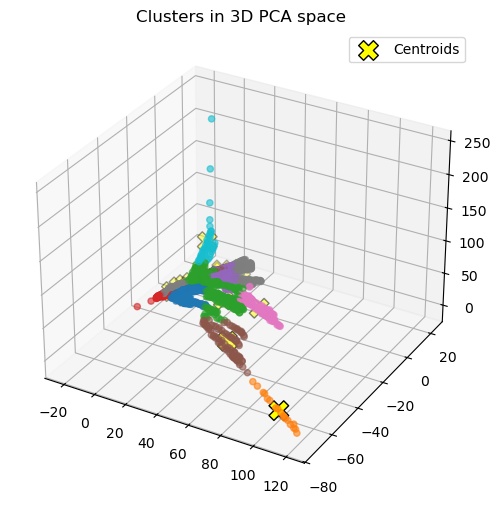

In [118]:
pca_visualise(scaled_mean, labels, centroids,number_of_dims=2)#FOR 2D VISUALIZATION
pca_visualise(scaled_mean, labels, centroids,number_of_dims=3)#FOR 3D VISILISATION

## 7. Creative Extensions(I use silhoutte scores to plot and compare that to my loss function)

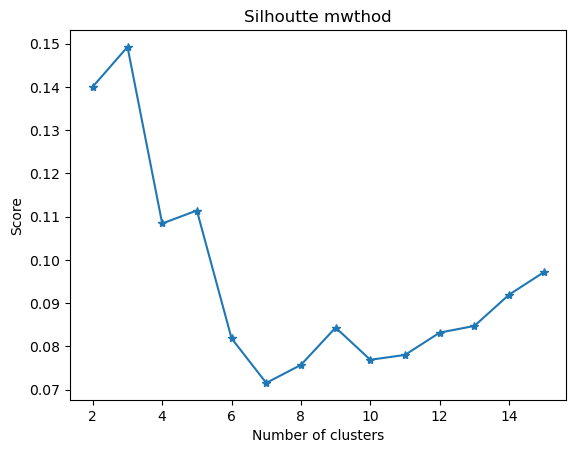

In [119]:
from sklearn.metrics import silhouette_score
scores =[]
for k in range(2,16):
    labels, centroids, _, _, _, _ = my_kmeans(scaled_mean, k, init="kmeans++", seed=56)
    score = silhouette_score(scaled_mean, labels, metric="euclidean")
    scores.append(score)
plt.plot(range(2,16),scores,marker="*")
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Silhoutte mwthod")
plt.show()